# Giriş
Bu notebook, Akbank Derin Öğrenme Bootcamp projesi kapsamında hazırlanmıştır.  
İlk olarak Kaggle çalışma ortamı hazırlanmış ve gerekli kütüphaneler yüklenmiştir.  

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/14986.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/3138.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/1700.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/16257.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/2863.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/771.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/12167.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/17643.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/6560.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/10162.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/4009.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/15823.jpg
/kaggle/input/intel-image-classification/seg_tr

# Adım 1 — Veri Yükleme ve Hazırlık
- Kaggle’da eklediğimiz **Intel Image Classification** veri setini kullanıyoruz.  
- **train/validation/test** ayrımını generator’larla kuruyoruz (validation %20).  
- Sınıf isimlerini yazdırıp birkaç örnek görüntü gösteriyoruz.





2025-09-26 19:30:17.428686: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758915017.768500      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758915017.863078      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
Sınıflar: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


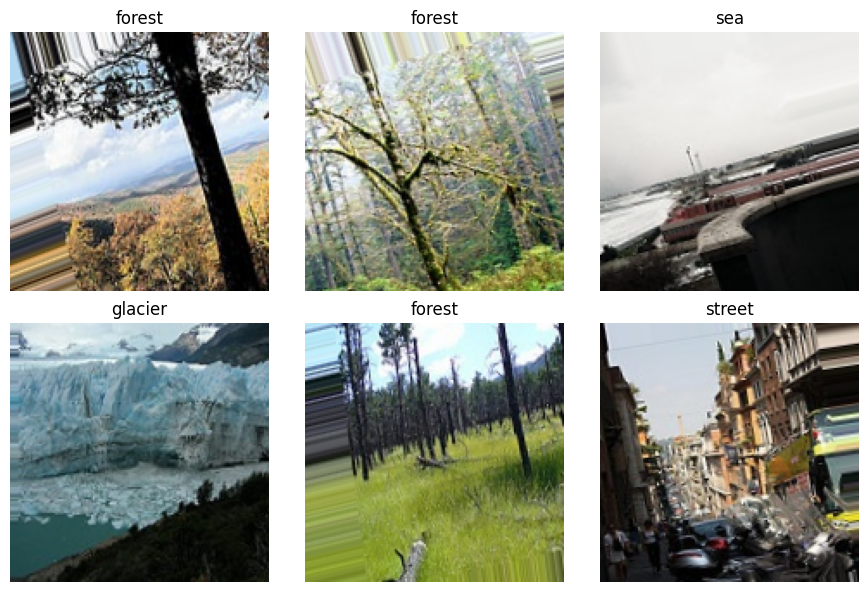

In [2]:
import os, numpy as np, matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Dataset yolları (Kaggle "Add data" yaptığın haliyle)
base_dir = "/kaggle/input/intel-image-classification"
train_dir = os.path.join(base_dir, "seg_train/seg_train")
test_dir  = os.path.join(base_dir, "seg_test/seg_test")

# Generator'lar
IMG_SIZE   = (150, 150)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.20,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode="categorical", subset="training", shuffle=True
)
val_generator = train_datagen.flow_from_directory(
    train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode="categorical", subset="validation", shuffle=False
)
test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode="categorical", shuffle=False
)

# Sınıflar ve örnek görseller
class_labels = list(train_generator.class_indices.keys())
print("Sınıflar:", class_labels)

xb, yb = next(train_generator)
plt.figure(figsize=(9,6))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(xb[i])
    plt.title(class_labels[np.argmax(yb[i])])
    plt.axis("off")
plt.tight_layout()
plt.show()


# Adım 2 — CNN Modeli ve Eğitim
Bu adımda 3 bloktan oluşan bir CNN mimarisi kuruyor ve **validation** takibiyle eğitiyoruz.  
- Mimari: 3×(Conv2D + MaxPool) + Dropout + Dense  
- Kayıp: `categorical_crossentropy`, Optimizasyon: `Adam(lr=1e-3)`  
- Aşırı öğrenmeyi engellemek için **EarlyStopping** ve **ReduceLROnPlateau** kullanılıyor.


In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# train_generator ve val_generator önceki adımda tanımlandı
num_classes = train_generator.num_classes
input_shape = (150, 150, 3)

model = models.Sequential([
    layers.Input(shape=input_shape),

    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(),

    layers.Dropout(0.35),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.40),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

es  = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
ckp = ModelCheckpoint('best_cnn_basic.keras', monitor='val_accuracy', save_best_only=True, verbose=1)

EPOCHS = 12
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=[es, rlr, ckp],
    verbose=1
)


I0000 00:00:1758915037.603685      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1758915037.604331      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/12


I0000 00:00:1758915042.478873     125 service.cc:148] XLA service 0x7fa07c007810 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758915042.480745     125 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1758915042.480766     125 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1758915042.909079     125 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/351 ━━━━━━━━━━━━━━━━━━━━ 48:09 8s/step - accuracy: 0.1562 - loss: 1.8139

I0000 00:00:1758915047.897036     125 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - accuracy: 0.4448 - loss: 1.3611
Epoch 1: val_accuracy improved from -inf to 0.62482, saving model to best_cnn_basic.keras
351/351 ━━━━━━━━━━━━━━━━━━━━ 129s 345ms/step - accuracy: 0.4450 - loss: 1.3606 - val_accuracy: 0.6248 - val_loss: 0.9551 - learning_rate: 0.0010
Epoch 2/12
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.6255 - loss: 0.9987
Epoch 2: val_accuracy improved from 0.62482 to 0.68295, saving model to best_cnn_basic.keras
351/351 ━━━━━━━━━━━━━━━━━━━━ 77s 219ms/step - accuracy: 0.6255 - loss: 0.9985 - val_accuracy: 0.6830 - val_loss: 0.8394 - learning_rate: 0.0010
Epoch 3/12
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.6774 - loss: 0.8699
Epoch 3: val_accuracy improved from 0.68295 to 0.70613, saving model to best_cnn_basic.keras
351/351 ━━━━━━━━━━━━━━━━━━━━ 78s 222ms/step - accuracy: 0.6774 - loss: 0.8699 - val_accuracy: 0.7061 - val_loss: 0.7817 - learning_rate: 0.0010
Epoch 4/12
351/351 ━━━━━━━━━━━━━━━━━━━

# Adım 3 — Accuracy ve Loss Grafikleri
Eğitim sürecinde **epoch bazında** doğruluk (accuracy) ve kayıp (loss) değerlerinin değişimini görselleştiriyoruz.  
Bu grafikler sayesinde modelin **öğrenme eğrisini** ve olası **overfitting/underfitting** durumunu yorumlayacağız.


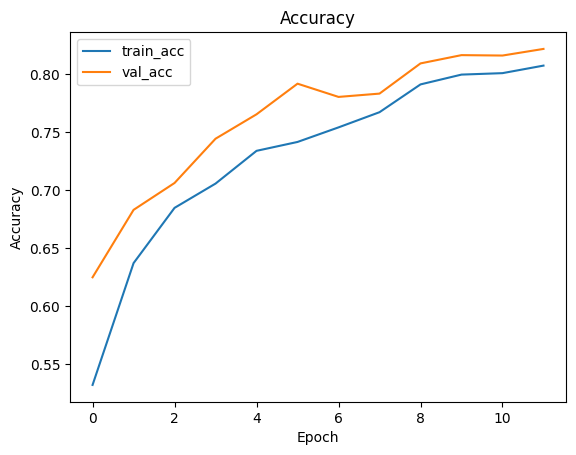

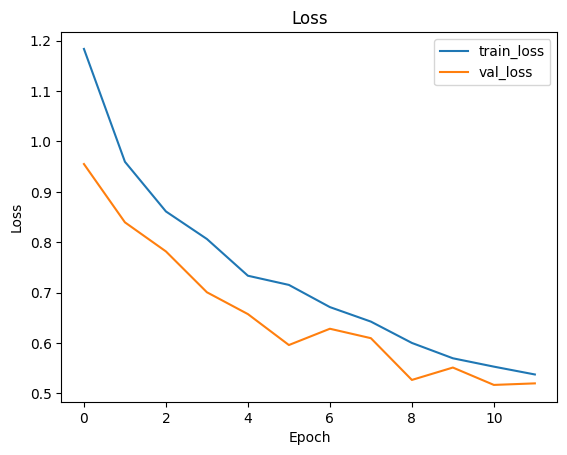

In [4]:
import matplotlib.pyplot as plt
import os

os.makedirs("/kaggle/working/figs", exist_ok=True)

# Accuracy
plt.figure()
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.title('Accuracy')
plt.savefig("/kaggle/working/figs/accuracy.png", dpi=150, bbox_inches='tight')
plt.show()

# Loss
plt.figure()
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.title('Loss')
plt.savefig("/kaggle/working/figs/loss.png", dpi=150, bbox_inches='tight')
plt.show()


# Adım 4 — Test Skoru, Confusion Matrix ve Classification Report
Bu bölümde modeli **test seti** üzerinde değerlendiriyoruz:
- **Test Accuracy / Loss** değerleri,
- **Confusion Matrix** (hangi sınıflarda karışma var?),
- **Classification Report** (precision, recall, f1-score).

Bu çıktılar, modelin hangi sınıflarda güçlü/zayıf olduğunu göstermesi açısından kritik öneme sahiptir.


Test Accuracy: 0.8450 | Test Loss: 0.4284


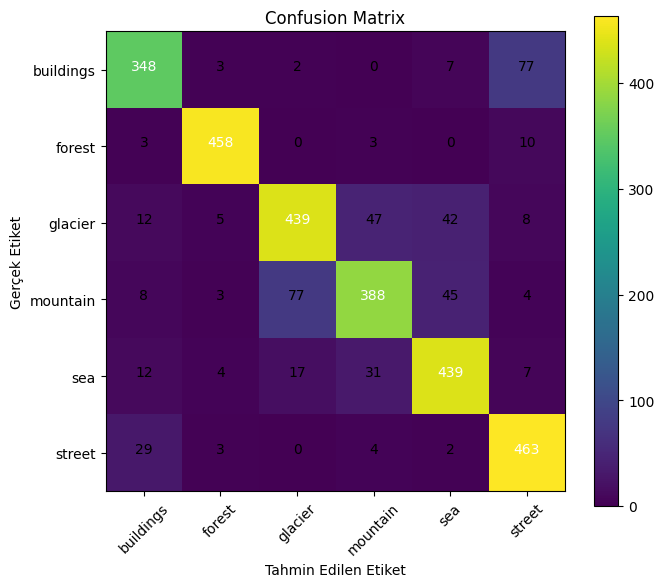


Classification Report:

              precision    recall  f1-score   support

   buildings       0.84      0.80      0.82       437
      forest       0.96      0.97      0.96       474
     glacier       0.82      0.79      0.81       553
    mountain       0.82      0.74      0.78       525
         sea       0.82      0.86      0.84       510
      street       0.81      0.92      0.87       501

    accuracy                           0.84      3000
   macro avg       0.85      0.85      0.85      3000
weighted avg       0.85      0.84      0.84      3000



In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import itertools, os

# 1) Test skoru
test_loss, test_acc = model.evaluate(test_generator, verbose=0)
print(f"Test Accuracy: {test_acc:.4f} | Test Loss: {test_loss:.4f}")

# 2) Tahminler
test_generator.reset()
y_prob = model.predict(test_generator, verbose=0)
y_pred = np.argmax(y_prob, axis=1)
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())

# 3) Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# 4) Görselleştir ve kaydet
os.makedirs("/kaggle/working/figs", exist_ok=True)
plt.figure(figsize=(7,6))
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix'); plt.colorbar()
ticks = np.arange(len(class_names))
plt.xticks(ticks, class_names, rotation=45)
plt.yticks(ticks, class_names)

thresh = cm.max() / 2.0
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('Gerçek Etiket'); plt.xlabel('Tahmin Edilen Etiket')
plt.tight_layout()
plt.savefig("/kaggle/working/figs/confusion_matrix.png", dpi=150, bbox_inches='tight')
plt.show()

# 5) Classification Report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))


# Adım 5 — Grad-CAM Isı Haritaları
Bu adımda modelin tahmin yaparken **hangi bölgelere odaklandığını** görselleştiriyoruz.
Aşağıdaki hücre:
- Eğitilmiş `model`i fonksiyonel grafikte **katman katman** çağırır,
- Son **Conv2D** aktivasyonunu ve nihai çıktıyı aynı grafikte üretir,
- Test setinden **6 rastgele görüntü** için Grad-CAM ısı haritalarını hesaplayıp `figs/gradcam_*.png` olarak kaydeder.


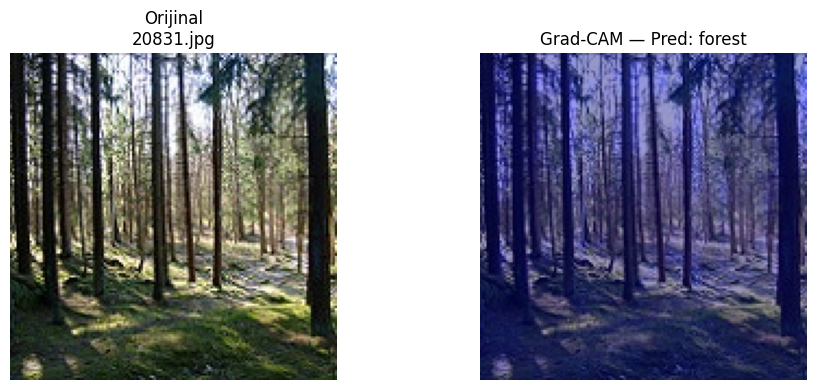

Kaydedildi: /kaggle/working/figs/gradcam_1.png


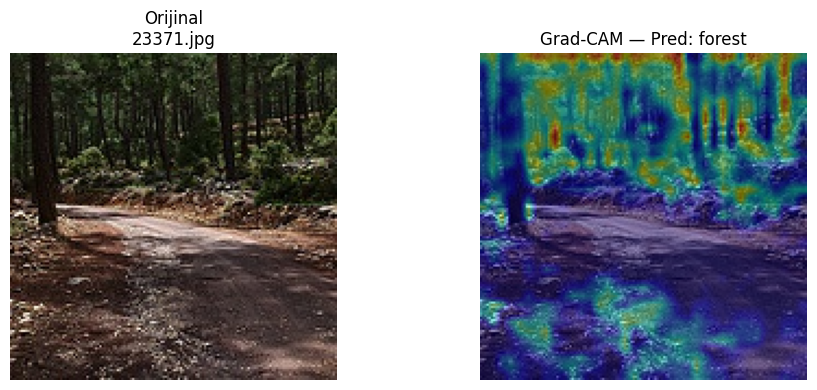

Kaydedildi: /kaggle/working/figs/gradcam_2.png


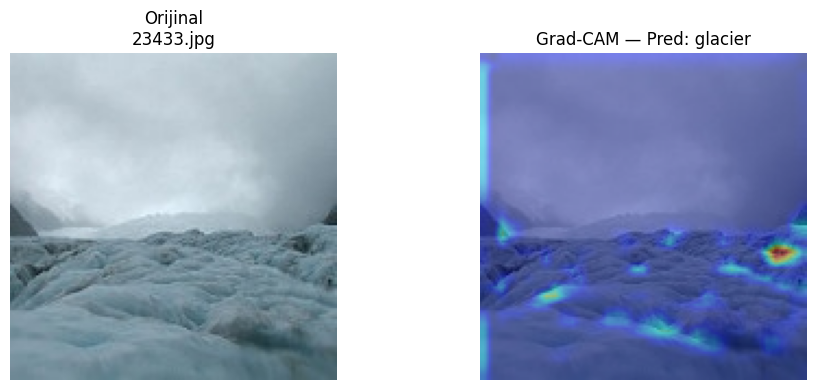

Kaydedildi: /kaggle/working/figs/gradcam_3.png


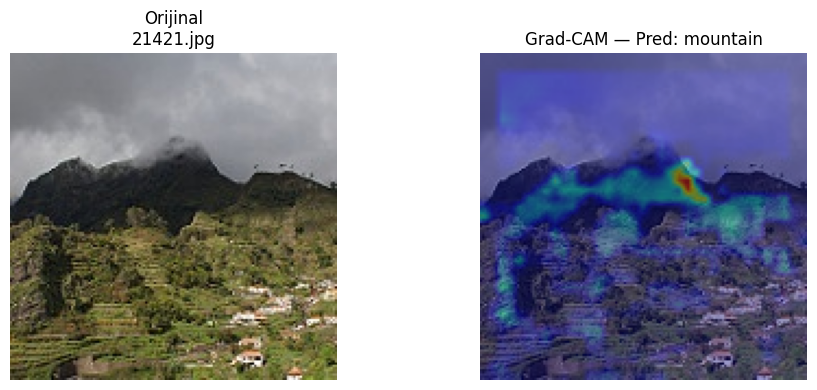

Kaydedildi: /kaggle/working/figs/gradcam_4.png


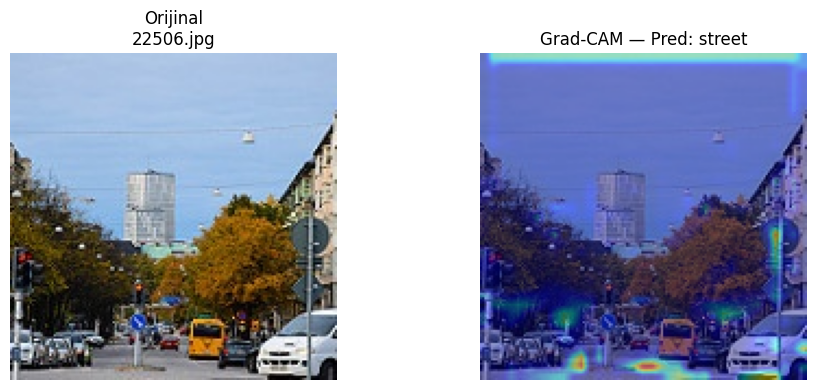

Kaydedildi: /kaggle/working/figs/gradcam_5.png


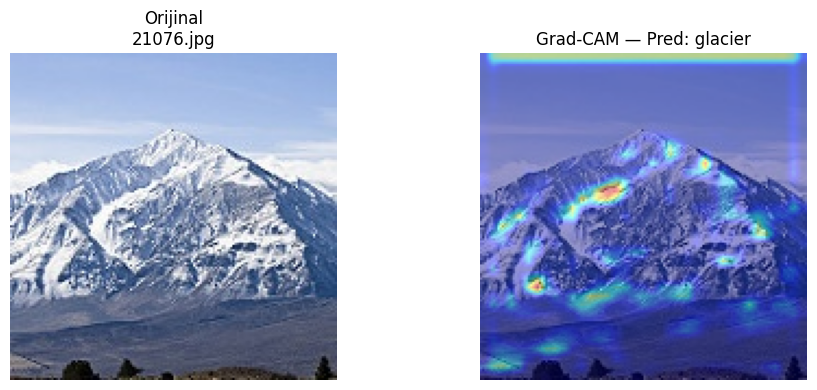

Kaydedildi: /kaggle/working/figs/gradcam_6.png


In [6]:
import os, random, numpy as np, matplotlib.pyplot as plt, cv2, tensorflow as tf
from tensorflow.keras import Model

# Kayıt klasörü
os.makedirs("/kaggle/working/figs", exist_ok=True)

# 1) Sequential modeli fonksiyonel grafikte KATMAN KATMAN çağır
input_shape = (150,150,3)
inp = tf.keras.Input(shape=input_shape)
x = inp
last_conv_act = None

for layer in model.layers:
    # InputLayer'ı atla; diğer tüm katmanları sırayla uygula
    if isinstance(layer, tf.keras.layers.InputLayer):
        continue
    x = layer(x)
    if isinstance(layer, tf.keras.layers.Conv2D):
        last_conv_act = x

assert last_conv_act is not None, "Modelde Conv2D katmanı bulunamadı."
func_model = Model(inputs=inp, outputs=[last_conv_act, x])  # x: nihai çıkış

# 2) Grad-CAM hesaplayıcı
def grad_cam(img_array):  # img_array: (1,150,150,3)
    with tf.GradientTape() as tape:
        conv_out, preds = func_model(img_array, training=False)
        pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    grads = tape.gradient(class_channel, conv_out)        # dY/dA
    weights = tf.reduce_mean(grads, axis=(0,1,2))         # kanal ağırlıkları

    conv_out = conv_out[0].numpy()                        # (H,W,C)
    weights  = weights.numpy()                            # (C,)
    conv_out *= weights                                   # kanal ağırlıklarıyla çarp

    heatmap = np.mean(conv_out, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap = heatmap / (np.max(heatmap) + 1e-8)
    return heatmap, int(pred_index.numpy())

# 3) Test setinden 6 rastgele görüntü seç
SAMPLES = 6
IMG_SIZE = (150,150)
class_names = list(test_generator.class_indices.keys())

paths = []
for cls in os.listdir(test_dir):
    cls_dir = os.path.join(test_dir, cls)
    if os.path.isdir(cls_dir):
        for f in os.listdir(cls_dir):
            if f.lower().endswith((".jpg",".jpeg",".png",".bmp")):
                paths.append(os.path.join(cls_dir, f))
random.shuffle(paths)
paths = paths[:SAMPLES]

# 4) Görselleştir ve kaydet
for i, path in enumerate(paths, start=1):
    # Orijinal görüntü
    orig_bgr = cv2.imread(path)
    orig = cv2.cvtColor(orig_bgr, cv2.COLOR_BGR2RGB)

    # Girdi hazırlığı
    img_resized = cv2.resize(orig, IMG_SIZE).astype("float32")/255.0
    img_in = np.expand_dims(img_resized, axis=0)

    # Grad-CAM
    heatmap, pred_id = grad_cam(img_in)
    pred_name = class_names[pred_id]

    # Bindirme
    heat = cv2.resize(heatmap, (orig.shape[1], orig.shape[0]))
    heat_u8 = np.uint8(255 * heat)
    heat_col = cv2.applyColorMap(heat_u8, cv2.COLORMAP_JET)
    superimposed = cv2.addWeighted(orig, 0.6, cv2.cvtColor(heat_col, cv2.COLOR_BGR2RGB), 0.4, 0)

    # Göster + kaydet
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1); plt.imshow(orig); plt.title(f"Orijinal\n{os.path.basename(path)}"); plt.axis('off')
    plt.subplot(1,2,2); plt.imshow(superimposed); plt.title(f"Grad-CAM — Pred: {pred_name}"); plt.axis('off')
    out_path = f"/kaggle/working/figs/gradcam_{i}.png"
    plt.tight_layout(); plt.savefig(out_path, dpi=150, bbox_inches='tight'); plt.show()
    print("Kaydedildi:", out_path)


# Adım 6 — Hiperparametre Denemeleri
Bu adımda farklı **learning rate** ve **dropout** değerleri deneriz; her deneme için en yüksek **val_accuracy** kaydedilir.  
En iyi denemeyi test setinde değerlendirip sonucu yazdırırız.


In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

def build_cnn(lr=1e-3, dropout=0.40, input_shape=(150,150,3), num_classes=None):
    if num_classes is None:
        num_classes = train_generator.num_classes
    m = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(32, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D(),
        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D(),
        layers.Dropout(0.30),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(dropout),
        layers.Dense(num_classes, activation='softmax')
    ])
    m.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss='categorical_crossentropy', metrics=['accuracy'])
    return m

trials = [
    {"name":"adam_lr1e-3_do0.40", "lr":1e-3,  "dropout":0.40},
    {"name":"adam_lr5e-4_do0.50", "lr":5e-4,  "dropout":0.50},
    {"name":"adam_lr2e-3_do0.30", "lr":2e-3,  "dropout":0.30},
]

summary = []
EPOCHS = 3  # deneme süresi
callbacks=[EarlyStopping(monitor='val_accuracy', patience=2, restore_best_weights=True)]

for t in trials:
    print(f"\n===== {t['name']} =====")
    m = build_cnn(lr=t["lr"], dropout=t["dropout"])
    h = m.fit(
        train_generator,
        validation_data=val_generator,
        epochs=EPOCHS,
        callbacks=callbacks,
        verbose=1
    )
    best_val = float(np.max(h.history["val_accuracy"]))
    summary.append({"trial": t["name"], "best_val_acc": best_val, "model": m})
    print(f"best_val_acc={best_val:.4f}")

# En iyi denemeyi seç
best = sorted(summary, key=lambda x: x["best_val_acc"], reverse=True)[0]
best_model = best["model"]
print("\n=== En iyi deneme ===")
print(best["trial"], " | best_val_acc=", round(best["best_val_acc"],4))

# Test setinde ölç
test_loss, test_acc = best_model.evaluate(test_generator, verbose=0)
print(f"Test Accuracy (best trial): {test_acc:.4f} | Test Loss: {test_loss:.4f}")



===== adam_lr1e-3_do0.40 =====
Epoch 1/3
351/351 ━━━━━━━━━━━━━━━━━━━━ 84s 228ms/step - accuracy: 0.4829 - loss: 1.3038 - val_accuracy: 0.6259 - val_loss: 0.9613
Epoch 2/3
351/351 ━━━━━━━━━━━━━━━━━━━━ 78s 221ms/step - accuracy: 0.6253 - loss: 0.9944 - val_accuracy: 0.7129 - val_loss: 0.7949
Epoch 3/3
351/351 ━━━━━━━━━━━━━━━━━━━━ 77s 219ms/step - accuracy: 0.6958 - loss: 0.8462 - val_accuracy: 0.6961 - val_loss: 0.8498
best_val_acc=0.7129

===== adam_lr5e-4_do0.50 =====
Epoch 1/3
351/351 ━━━━━━━━━━━━━━━━━━━━ 84s 228ms/step - accuracy: 0.4286 - loss: 1.3849 - val_accuracy: 0.6177 - val_loss: 0.9717
Epoch 2/3
351/351 ━━━━━━━━━━━━━━━━━━━━ 77s 219ms/step - accuracy: 0.6068 - loss: 1.0399 - val_accuracy: 0.6822 - val_loss: 0.8618
Epoch 3/3
351/351 ━━━━━━━━━━━━━━━━━━━━ 77s 219ms/step - accuracy: 0.6626 - loss: 0.8955 - val_accuracy: 0.7418 - val_loss: 0.7414
best_val_acc=0.7418

===== adam_lr2e-3_do0.30 =====
Epoch 1/3
351/351 ━━━━━━━━━━━━━━━━━━━━ 85s 229ms/step - accuracy: 0.4538 - loss: 1.3

# Adım 7 — Yeni Görsel Üzerinde Test
Bu bölümde eğittiğimiz CNN modelini kullanarak **daha önce eğitim/test setinde olmayan tek bir görseli** sınıflandırıyoruz.  
Böylece modelin pratikte nasıl çalıştığını gösteriyoruz.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step
Tahmin: forest | Güven: 1.00


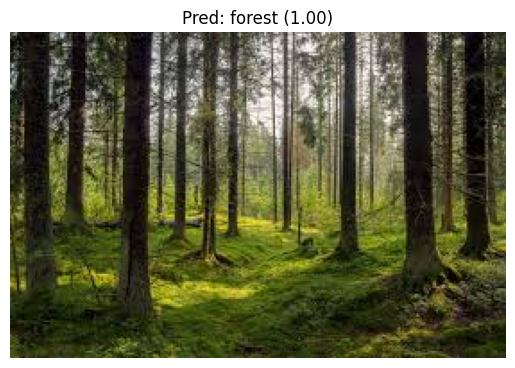

In [8]:
import cv2
import numpy as np

# Test etmek istediğimiz görselin yolu
img_path = "/kaggle/input/image1/images.jpeg"

# Görseli oku ve model girişine hazırla
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_resized = cv2.resize(img, (150,150)).astype("float32")/255.0
img_in = np.expand_dims(img_resized, axis=0)

# Tahmin
preds = model.predict(img_in)
pred_class = class_names[np.argmax(preds)]
confidence = np.max(preds)

print(f"Tahmin: {pred_class} | Güven: {confidence:.2f}")

# Görseli tahmin etiketiyle göster
import matplotlib.pyplot as plt
plt.imshow(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB))
plt.title(f"Pred: {pred_class} ({confidence:.2f})")
plt.axis('off')
plt.show()
